# <center> Predicting topic model </center>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib_venn import venn2
import re
import nltk
import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
np.random.seed(sum(map(ord, "categorical")))
%matplotlib inline

Using TensorFlow backend.
/home/saurabh/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reading Data¶

* Reading training data

I read 10 datasets from disk

In [2]:
numberOfDatasets = 10
def readData(numberOfDatasets, counter):
    df = pd.DataFrame()
    for i in range(counter, counter+numberOfDatasets):
        tempDf = pd.read_csv("./Part"+str(i+1)+".csv")
        df = df.append(tempDf)
    return df

train = readData(numberOfDatasets,0)
print ("Total number of records read : ", len(train))
train.head()


Total number of records read :  472120


,learnerId,nationality,grade,level,topic,text
0,84805,mx,90,5,Summarizing a story,make is a live''s jeans an shit favorit...
1,139062,cn,90,6,Complaining about a meal,19th June 2012I went to a restaurant an...
2,162010,tw,83,6,Writing a movie plot,"Although Isabella had married, but his ..."
3,60036,ru,94,1,Taking inventory in the office,The code of conduct: - do not disclose ...
4,88813,mx,100,8,Describing a business trip,I have fantastic news. Finally I met wi...


## Visualizing topic distribution

In [3]:
print ("Total number of topics : ", len(Counter(train['topic'])))
Counter(train['topic'])

Total number of topics :  128


Counter({'Applying for a home loan': 82,
         'Applying for sponsorship': 172,
         'Applying to be a fitness trainer': 1717,
         'Asking a friend to shop for you': 2604,
         'Asking for leave': 1336,
         'Attending a leadership course': 430,
         'Attending a robotics conference': 186,
         'Attending a seminar on stress reduction': 215,
         'Buying a painting for a friend': 557,
         'Buying clothes from a catalog': 8699,
         'Choosing a birthday present': 2279,
         'Choosing a renewable energy source': 255,
         'Claiming back your security deposit': 553,
         'Comparing two demographic groups': 490,
         'Comparing two online retailers': 134,
         'Complaining about a meal': 1075,
         'Complaining about chores': 3330,
         'Conducting a performance appraisal': 124,
         'Congratulating a friend on an award': 723,
         'Covering a news story': 170,
         'Creating an office dress code': 3146,
     

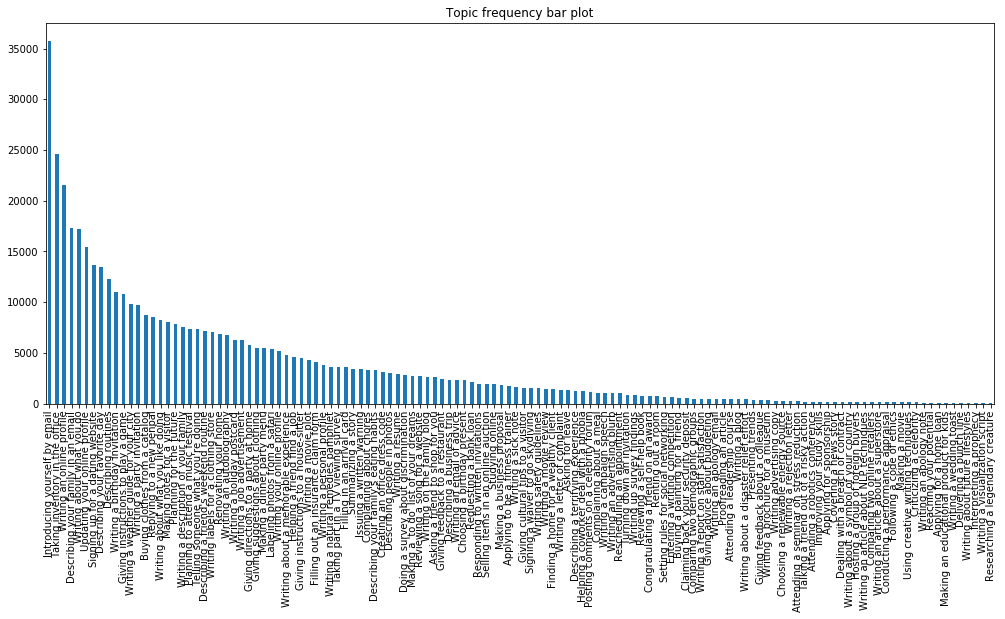

In [4]:
plt.figure(figsize=(17,7))
plt.title("Topic frequency bar plot")
train['topic'].value_counts().plot(kind='bar')
plt.show()

In [5]:
train['topic'] = train['topic'].astype('category')

In [6]:
test = readData(2, 10)
test['topic'] = test['topic'].astype('category')
print ("No. of records read : ", len(test))
test.head()

No. of records read :  94424


,learnerId,nationality,grade,level,topic,text
0,34458,br,90,7,Writing a job advertisement,Open possition for Finance Administrati...
1,136384,mx,79,4,Writing about what you like doing,Hello Dillo. how are you?thank you for ...
2,135078,it,95,3,Replying to a new penpal,"Hi, my names NATASCIA. Im twenty-eight...."
3,21417,ru,100,3,Describing a friend's weekend routine,"On Saturday, he goes swimming at 11:30a..."
4,170106,br,95,1,Writing labels for a clothing store,"This black skirt is 15,00. These red an..."


## Pre-processing
Doing pre-processing of text data:

* lowercase of text
* remove of all puncuation and keeping onl alphanumeric characters
* tokenizing using nltk and re-merging for removal of bad spellings

In [7]:
train['text']=train['text'].apply(lambda x : " ".join(nltk.tokenize.word_tokenize(re.sub(r'\W+', " ", x.lower()))))

test['text']=test['text'].apply(lambda x : " ".join(nltk.tokenize.word_tokenize(re.sub(r'\W+', " ", x.lower()))))

## Building X_train, Y_train, X_test and Y_test for Topic

In [8]:
X_train, Y_train = train['text'].values, train['topic'].values
X_test, Y_test = test['text'].values, test['topic'].values
X_train[0:5]

array(['make is a live s jeans an shit favorit make is the ralp laurens polo is somewhat expensive but i think worth the money mifavorit foot wear is the sport shoe is nike make i think are is berygood quality and comfortables',
       '19th june 2012i went to a restaurant and i had a terrible meal the starter soup was bland the dessert was too sweet the horrible is red wine and coffee was disgusting bitter also the steak was overcooked and there was chilli powder with it it was very unhappy meal sharon',
       'although isabella had married but his husband is very awful and violent so she want to divorce early they were talking very happy after that they are talking on the ship every night day after day john and isabella fall in love and they decide to have an elopement finally they were hold a wedding in other a country and had three children after three years the story have a happy ending',
       'the code of conduct do not disclose confidential information keep your workspace nea

## Converting Y to one-hot

In [9]:
Y_OneHot_Train = pd.get_dummies(Y_train)
Y_OneHot_Test = pd.get_dummies(Y_test)
classes = len(Y_OneHot_Train.columns.values)
Y_OneHot_Train.head()

,Applying for a home loan,Applying for sponsorship,Applying to be a fitness trainer,Asking a friend to shop for you,Asking for leave,Attending a leadership course,Attending a robotics conference,Attending a seminar on stress reduction,Buying a painting for a friend,Buying clothes from a catalog,...,Writing an article about NLP techniques,Writing an article about a superstore,Writing an autobiography,Writing an email of advice,Writing an online profile,Writing labels for a clothing store,Writing on the family blog,Writing safety guidelines,Writing up survey findings,Writing your online profile
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
Y_OneHot_Train = Y_OneHot_Train.values
Y_OneHot_Test = Y_OneHot_Test.values
Y_OneHot_Train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Reading GloVe

In [11]:
def readGlove(filename):   
    with open(filename, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map, words

gloveVecFile = "./glove.6B.50d.txt"
words_to_index, index_to_words, word_to_vec_map, words = readGlove(gloveVecFile)

## Converting sentences to indices vector

In [12]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. One can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros(shape=(m, max_len))
    
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().strip().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except KeyError as e:
                X_indices[i, j] = word_to_index["unk"]
            # Increment j to j + 1
            j = j + 1
            if j>=max_len:
                break
    
    return X_indices

## Defining pre-training embedding layer

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        try:
            emb_matrix[index, :] = word_to_vec_map[word]
        except Exception as e:
            print ("Exception {0} occured for word {1}".format(e, word))

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## Designing model

In [14]:
def nation(input_shape, word_to_vec_map, word_to_index):    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(264)(embeddings)
#     X = LSTM(264)(embeddings)
   
    # Add dropout with a probability of 0.5 to prevent overfitting
    X = Dropout(0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
#     X = LSTM(264)(X)
    
#     # Add dropout with a probability of 0.5
#     X = Dropout(rate = 0.5)(X)

    # Propagate X through a Dense layer with softmax activation to get back a batch of 191-dimensional vectors.
    X = Dense(classes, activation='relu')(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    
    return model

In [15]:
maxLen = 200 # Determined from the EDA notebook
model = nation((maxLen,), word_to_vec_map, words_to_index)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 264)               332640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               33920     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
Total params: 20,366,610.0
Trainable params: 366,560.0
Non-trainable 

In [16]:
## Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
X_train_indices = sentences_to_indices(X_train, words_to_index, maxLen)

## Fitting the model

In [18]:
model.fit(X_train_indices, Y_OneHot_Train, epochs = 1, batch_size = 50, shuffle=True, validation_split=0.2)

Train on 377696 samples, validate on 94424 samples
Epoch 1/1
377696/377696 [==============================] - 8246s - loss: 2.7157 - acc: 0.3488 - val_loss: 1.3610 - val_acc: 0.6686


In [19]:
model.save("./TopicVsText.hdf5")

## Running model using K-fold cross validation
Below code is commented.

* Uncomment and run the below cell to train the model using 10-fold cross validation
* I did not do this, because it was taking too much time - 2 hrs for 1 epoch on 1 validation data
* Feel free to change number of epochs

In [22]:
# seed = 8
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# cvscores = []
# for train, test in kfold.split(X_train, Y_train):
#     # Fit the model
#     X_train_indices = sentences_to_indices(X_train[train], words_to_index, maxLen)
#     Y_OneHot_Train = pd.get_dummies(Y_train[train]).values
    
#     model = nation((maxLen,), word_to_vec_map, words_to_index)
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print (model.fit(X_train_indices, Y_OneHot_Train, epochs=2, batch_size=50, verbose=1))
    
#     # evaluate the model
#     X_test_indices = sentences_to_indices(X_train[test], words_to_index, maxLen)
#     pred = model.predict(X_test_indices, verbose=1)
#     Y_test_pred = np.argmax(pred, axis=1)
#     Y_test_map = {}
#     for index, country in enumerate(Y_train[train].categories.values):
#         Y_test_map[country] = index
#     Y_test_actual= []
#     for value in Y_train[test]:
#         Y_test_actual.append(Y_test_map.get(value))
        
#     scores= np.mean(np.equal(Y_test_actual, Y_test_pred))
#     print("acc: %.2f%%" % (100*scores))
#     cvscores.append(scores * 100)
# print("Final k-fold result : %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Testing the model¶

Below are some of the metrics on testing data

In [22]:
X_test_indices = sentences_to_indices(X_test, words_to_index, max_len = maxLen)

In [23]:
pred = model.predict(X_test_indices, verbose=1)  

94424/94424 [==============================] - 621s   


In [24]:
pred
Y_test_pred = np.argmax(pred, axis=1)

Y_test_map = {}
for index, country in enumerate(Y_train.categories.values):
    Y_test_map[country] = index
    
def getYTestActual(Y_test_map, Y_test):
    Y_test_actual= []
    for value in Y_test:
        Y_test_actual.append(Y_test_map.get(value))
    return Y_test_actual

Y_test_actual = getYTestActual(Y_test_map, Y_test)

In [25]:
print ("Testing set accuracy : {0}%".format(100*np.mean(np.equal(Y_test_actual, Y_test_pred))))

Testing set accuracy : 67.10052529018046%


## Testing the model on any validation data set
* I have created 25 files of approx. 18MB size each. 1-10 are used for training and 11-12 are used for validation
* Provide any File Part number (except 1 - 12, 1-10 is used for training and 11-12 are already used for validation) from 13-25

In [32]:
## Provide any part number for validation
part_no = 23 # user choice
validation_df = pd.read_csv("./Part"+str(part_no)+".csv")
X_validation_indices = sentences_to_indices(validation_df['text'].values, words_to_index, max_len = maxLen)
Y_validation_actual = getYTestActual(Y_test_map, validation_df['topic'].values)

In [33]:
print ("Loading model from disk ...")
model = load_model("./TopicVsText.hdf5")
print ("model loaded")
print (model.summary())
pred = model.predict(X_validation_indices, verbose=1) 
Y_validation_pred = np.argmax(pred, axis=1)
print ("Validation set accuracy : {0}%".format(100*np.mean(np.equal(Y_validation_actual, Y_validation_pred))))

Loading model from disk ...
model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 264)               332640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               33920     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
Total params: 20,366,610.0
Trainable params: 366,560.0
Non-trainable params: 20,000,050.0
___________